In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from multiinstance.em import generateBags

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as ss
from sklearn.cluster import KMeans

from multiinstance.utils import estimate

from easydict import EasyDict

from dist_curve.transforms import getOptimalTransform

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import adjusted_rand_score

from scipy.spatial.distance import cdist

starting in the simplest case: 1 bag with 1 pair of components

In [3]:
posMeans = [[-2,-6], [6,6]]
negMeans = [[-1,-2], [4,3]]

In [4]:
bags = generateBags(100,pos_means=posMeans,
                    neg_means=negMeans,NPos=25,NUnlabeled=75)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
for b,a in zip(bags,ax):
    a.scatter(b.x_unlabeled[:,0], b.x_unlabeled[:,1],color="blue",alpha=.5)
    a.scatter(b.X_pos[:,0], b.X_pos[:,1],color="red",alpha=.5)

## Run K-Means Globally

In [5]:
globalPositives = np.concatenate([b.X_pos for b in bags])

In [6]:
kmeans= KMeans(n_clusters=2).fit(globalPositives)

I need to match the fitted cluster centers to the correct positive distribution

In [7]:
kmeans.clusterMap = cdist(kmeans.cluster_centers_, posMeans).argmin(1)

## Cluster Unlabeled Instances

In [8]:
for i,b in enumerate(bags):
    bags[i].unlabeled_cluster_assignment =kmeans.clusterMap[kmeans.predict(b.x_unlabeled)]

If rand score is high and the accuracy is low, the cluster labels need to be swapped

In [9]:
(bags[0].unlabeled_cluster_assignment[:bags[0].unlabeled_pos_componenet_labels.shape[0]] == bags[0].unlabeled_pos_componenet_labels).sum() / bags[0].unlabeled_pos_componenet_labels.shape[0]

1.0

In [10]:
adjusted_rand_score(bags[0].unlabeled_cluster_assignment[:bags[0].unlabeled_pos_componenet_labels.shape[0]],
                    bags[0].unlabeled_pos_componenet_labels)

1.0

## Run DistCurve on Each Cluster

In [11]:
NClusters = kmeans.cluster_centers_.shape[0]
clusterAlphaHats = np.zeros(NClusters)
for clusterNum in range(NClusters):
    unlabeled = np.concatenate([b.x_unlabeled[b.unlabeled_cluster_assignment == clusterNum] for b in bags])
    pos = globalPositives[kmeans.clusterMap[kmeans.labels_] == clusterNum]
    clusterAlphaHats[clusterNum], _ = estimate(pos, unlabeled)

## Run NNPU to get Posterior

In [ ]:
def logDensities(xi,compNum):
    p_x_y0 = ss.multivariate_normal.logpdf(xi, mean=negMeans[compNum],cov=np.eye(2))
    p_x_y1 = ss.multivariate_normal.logpdf(xi, mean=posMeans[compNum],cov=np.eye(2))
    return p_x_y0, p_x_y1

In [ ]:
def getPosterior(xi,compNum,alpha):
    f0,f1 = logDensities(xi,compNum)
    f0,f1= np.exp(f0), np.exp(f1) 
    posterior = alpha / (alpha + (1-alpha)*f0/f1)
    return posterior

In [ ]:
# def posteriorCorrection(xPositive, xUnlabeled, compNum):
#     alpha = clusterAlphaHats[compNum]
#     y = np.cgancatenate((np.ones(xPositive.shape[0]),
#                         np.zeros(xUnlabeled.shape[0])))
#     x = np.concatenate([xPositive, xUnlabeled])
#     tau,aucpu = getOptimalTransform(x,y)
#     tau = tau[xPositive.shape[0]:]
#     S0S1 = xUnlabeled.shape[0] / xPositive.shape[0]
#     post =  alpha * S0S1 * (tau / (1 - tau))
#     post[np.isinf(post)] = np.nanmax(post)
#     post[post <= 0] = 1e-3
#     return post

def posteriorCorrection(xPositive, xUnlabeled, compNum):
    c1 = xPositive.shape[0]
    cu = xUnlabeled.shape[0]
    alpha = clusterAlphaHats[compNum]
    lnf0,lnf1 = logDensities(xUnlabeled, compNum)
    f1 = np.exp(lnf1)
    f0 = np.exp(lnf0)
    k1 = c1 / (c1 + cu)
    k2 = (c1 + alpha * cu) / (c1 + cu)
    tau = k1 * f1 / (k2 * f1 + (1 - k2) * f0)
    S0S1= cu / c1
    post = alpha * S0S1 * (tau / (1 - tau))
    return post

## Convert Posterior To Component Density Ratio

In [12]:
def densityRatioFromPosterior(xi,compNum, alpha):
    posteriorXi = getPosterior(xi,compNum,alpha)
    return (alpha * (1 - posteriorXi)) / (posteriorXi * (1 - alpha))

In [15]:
def ratioFromPosteriorVec(posts, alpha):
    return (alpha * (1 - posts)) / (posts * (1 - alpha))

In [ ]:
def densityRatio(xi, compNum):
    p_x_y0, p_x_y1 = logDensities(xi,compNum)
    return np.exp(p_x_y0 - p_x_y1)

## Run EM Algorithm to get alpha, pi and rho

In [ ]:
aes = []
for i,b in enumerate(bags):
    etas = []
    for compNum in range(len(posMeans)):
        eta_i_j = np.array(.5)
#         ratios = np.array([densityRatio(xi,
#                                         compNum) for xi in b.x_unlabeled[b.unlabeled_cluster_assignment == compNum]])
        ratios = np.array([densityRatioFromPosterior(xi,
                                                     compNum,
                                                     clusterAlphaHats[compNum]) for xi in b.x_unlabeled[b.unlabeled_cluster_assignment == compNum]])
        plt.hist(np.log10(ratios))
        plt.show()
        for i in range(50):
            den = eta_i_j + (1 - eta_i_j) * ratios
            eta_i_j = np.mean(eta_i_j / den)
        etas.append(eta_i_j)
    eta_j = np.array(etas)
    gamma_j = np.unique(b.unlabeled_cluster_assignment,
                        return_counts=True)[1]/b.unlabeled_cluster_assignment.shape[0]
    alpha_j = eta_j.dot(gamma_j)
#     plt.hist(np.log10(ratios))
#     plt.show()
    print("alpha: {:.3f}, {:.3f}".format(alpha_j,b.alpha))
    aes.append(np.abs(b.alpha - alpha_j))
    pi_j = np.multiply(eta_j, gamma_j) / alpha_j
#     print("pi",pi_j, b.pi)
    rho_j = np.multiply(1 - eta_j, gamma_j) / (1 - alpha_j)
#     print("rho",rho_j, b.rho)
print(np.mean(aes))

## Estimate Posterior using all points in cluster

In [13]:
from multiinstance.nnpu import getPosterior as getNNPUPosterior

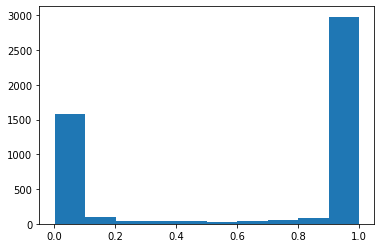

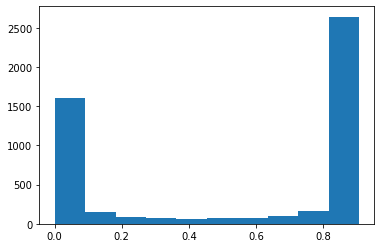

0.438 - 0.448
0.019 - 0.049
0.953 - 0.944
0.197 - 0.213
0.183 - 0.240
0.678 - 0.667
0.617 - 0.594
0.352 - 0.353
0.642 - 0.655
0.424 - 0.460
0.760 - 0.752
0.669 - 0.688
0.165 - 0.200
0.172 - 0.219
0.554 - 0.555
0.799 - 0.791
0.456 - 0.450
0.121 - 0.155
0.483 - 0.530
0.468 - 0.474
0.633 - 0.661
0.770 - 0.726
0.384 - 0.412
0.017 - 0.014
0.729 - 0.739
0.510 - 0.519
0.768 - 0.757
0.514 - 0.501
0.567 - 0.573
0.733 - 0.731
0.223 - 0.260
0.770 - 0.771
0.656 - 0.638
0.660 - 0.654
0.042 - 0.098
0.522 - 0.527
0.366 - 0.412
0.367 - 0.415
0.198 - 0.237
0.823 - 0.814
0.615 - 0.611
0.092 - 0.116
0.403 - 0.422
0.450 - 0.476
0.290 - 0.379
0.692 - 0.691
0.168 - 0.180
0.568 - 0.556
0.642 - 0.643
0.277 - 0.263
0.332 - 0.391
0.935 - 0.944
0.714 - 0.727
0.893 - 0.899
0.385 - 0.412
0.850 - 0.828
0.477 - 0.493
0.587 - 0.592
0.240 - 0.277
0.493 - 0.505
0.481 - 0.504
0.363 - 0.378
0.681 - 0.670
0.897 - 0.904
0.665 - 0.665
0.382 - 0.413
0.277 - 0.306
0.525 - 0.538
0.780 - 0.806
0.542 - 0.527
0.582 - 0.564
0.868 

In [18]:
etas = np.zeros((len(bags), len(posMeans)))
for compNum in range(len(posMeans)):
    # Use all points in the cluster to calculate the posterior
    unlabeledInCluster = [b.x_unlabeled[b.unlabeled_cluster_assignment == compNum] for b in bags]
    posInCluster = [b.X_pos[kmeans.clusterMap[kmeans.predict(b.X_pos)] == compNum] for b in bags]
    xP = np.concatenate(posInCluster)
    xU = np.concatenate(unlabeledInCluster)
    yP = np.ones(xP.shape[0])
    yU = np.ones(xU.shape[0]) * -1
    posteriors = getNNPUPosterior(np.concatenate((xP,xU)).astype(np.float32),
                                  np.concatenate((yP,yU)).astype(np.int32),
                                  clusterAlphaHats[compNum],
                                   args=EasyDict(d={'batchsize': 128,
                                                    'hdim': 4,
                                                    'epochs': 100,
                                                    'lr': 0.001,
                                                    'weightDecayRate': 0.005}))
    plt.hist(posteriors)
    plt.show()
    # Calculate bag eta_i_j
    for bagNum,b in enumerate(bags):
        # Extract posterior at unlabeled points in this bag and in this cluster
        mask = np.concatenate([np.ones(u.shape[0]) * (i == bagNum) for i,u in enumerate(unlabeledInCluster)]).astype(bool)
        mask = np.concatenate((np.concatenate([np.zeros(p.shape[0]) for p in posInCluster]),mask))
        posts = posteriors[mask.astype(bool)]
        # calculate density ratio given posterior values and cluster alphaHat
        ratios = ratioFromPosteriorVec(posts, clusterAlphaHats[compNum])
#         plt.hist(ratios)
#         plt.show()
        # Run EM algorithm
        eta_i_j = np.array(.5)
        for iterNum in range(500):
            den = eta_i_j + (1 - eta_i_j) * ratios
            eta_i_j = np.mean(eta_i_j / den)
        etas[bagNum,compNum] = eta_i_j

absErrs = []
for bagNum, b in enumerate(bags):
    eta_j = etas[bagNum]
    gamma_j = np.unique(b.unlabeled_cluster_assignment,
                        return_counts=True)[1]/b.unlabeled_cluster_assignment.shape[0]
    alpha_j = eta_j.dot(gamma_j)
    print("{:.3f} - {:.3f}".format(alpha_j, b.alpha))
    absErrs.append(np.abs(alpha_j - b.alpha))
print(np.mean(absErrs))